In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn
import warnings
warnings.filterwarnings('ignore')

# load dataset from input directory
df = pd.read_csv("../input/common-voice/cv-other-train.csv")

In [3]:
# Preparing data
start=df.shape
end = df[df['age'].notna()& df['gender'].notna() & df['accent'].notna()].shape
print("initial: {} final: {}".format(start, end))
df = df[['filename','age','gender']]
# Cleaning data
data = df[df['age'].notna() & df['gender'].notna()]
data.reset_index(inplace=True, drop=True)
data.head()

,filename,age,gender
0,cv-other-train/sample-000000.mp3,seventies,male
1,cv-other-train/sample-000001.mp3,twenties,male
2,cv-other-train/sample-000003.mp3,fourties,male
3,cv-other-train/sample-000005.mp3,twenties,male
4,cv-other-train/sample-000007.mp3,fifties,female


In [6]:
import librosa
import numpy as np
import pandas as pd
from scipy.fftpack import fft
from concurrent.futures import ProcessPoolExecutor #just ot make the code run faster by compiling in parallel

ds_path = "/kaggle/input/common-voice/cv-other-train/"

#function to extract useful features from audio data using librosa and scipy.fftpack for Fourier analysis
def feature_extraction(filename, sampling_rate=48000):
    path = "{}{}".format(ds_path, filename)
    features = list()
    audio, _ = librosa.load(path, sr=sampling_rate)
    
    # Fast Fourier Transform
    audio_fft = np.abs(fft(audio))

    gender = data[data['filename'] == filename].gender.values[0]
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sampling_rate))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sampling_rate))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sampling_rate))
    features.append(gender)
    features.append(spectral_centroid)
    features.append(spectral_bandwidth)
    features.append(spectral_rolloff)
    
    # Using FFT to extract MFCC features
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(audio_fft.reshape((-1, 1))), sr=sampling_rate)
    for el in mfcc:
        features.append(np.mean(el))
    
    return features

def extract_features_and_append_age(row):
    features = feature_extraction(row['filename'])
    features.append(row['age'])
    return features

def create_df_features_parallel(orig, max_workers=4):
    new_rows = []
    tot_rows = len(orig) - 1
    stop_counter = 60000
    #70001

    # Create a subset of the input DataFrame
    subset = orig.head(stop_counter)

    # Extract features and append age in parallel
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(extract_features_and_append_age, row) for _, row in subset.iterrows()]
        for idx, future in enumerate(futures):
            print("\r", end="")
            print("{}/{}".format(idx, tot_rows), end="", flush=True)
            new_rows.append(future.result())
    
    columns = ["gender", "spectral_centroid", "spectral_bandwidth", "spectral_rolloff"]
    columns += [f"fft{i+1}" for i in range(20)]  # Assuming 20 MFCC features
    columns += ["label"]
    return pd.DataFrame(new_rows, columns=columns)

df_features = create_df_features_parallel(data)
df_features.head()

59999/63501

,gender,spectral_centroid,spectral_bandwidth,spectral_rolloff,fft1,fft2,fft3,fft4,fft5,fft6,...,fft12,fft13,fft14,fft15,fft16,fft17,fft18,fft19,fft20,label
0,male,2980.710840,3456.849081,5938.964844,-5029.939941,0.080706,4844.999512,-0.041648,21.401812,-0.027057,...,-0.014567,-103.438812,0.032526,141.466339,0.039005,448.994141,-0.024607,161.986191,-0.032807,seventies
1,male,2017.167512,1996.540516,3752.874410,-3598.944092,0.117410,4824.307129,-0.044090,1205.707275,-0.067410,...,0.027982,-231.308533,0.064071,189.146240,0.029566,294.594513,0.000970,432.315247,-0.109390,twenties
2,male,1698.902684,2376.742054,3539.328835,-3647.560791,0.070723,5871.400391,-0.069311,-163.145813,-0.024781,...,-0.068997,368.174774,-0.050860,396.041809,-0.080127,66.155205,-0.066143,-160.526062,0.004905,fourties
3,male,1766.413719,1612.350426,2856.236925,-3103.161133,0.121857,5556.383789,-0.046706,1280.085449,-0.074217,...,0.036436,74.728928,0.019903,180.642334,0.012317,276.992645,0.004806,563.627686,-0.142633,twenties
4,female,3263.551451,3735.636409,6178.687500,-2278.166992,0.068708,4509.509277,-0.113346,-1732.360840,0.040222,...,0.046902,228.198593,0.038609,610.757202,-0.089471,-195.171387,0.037387,227.920166,0.010058,fifties


In [7]:
# Saving our prepared data after compiling it for several hours
df_features.to_csv('dataset_other.csv', index=False)

In [57]:
# Downloading prepared data
df_features1 = pd.read_csv('/kaggle/input/voicefft/mydataku.csv')
df_features2 = pd.read_csv('/kaggle/input/voicefft2/dataset_other.csv')

# Cleaning datafram from unwanted columns and joining two csv
first_column_name = df_features1.columns[0]
df_features1 = df_features1.drop(columns=first_column_name)
df_features = pd.concat([df_features1, df_features2])

# Changing male and female labels to 1 and 0
cleanup_nums = {"gender": {"male":1,"female":0,"other":0.5}}
df_features = df_features.replace(cleanup_nums)

# Getting rid of third gender for practical purposes of the model
df_features.drop(df_features[df_features["gender"] == 0.5].index, inplace = True)

# Since age won't be in the voice data
first_column_name = df_features.columns[-1]
df_features = df_features.drop(columns=first_column_name)
df_features.head()

,gender,spectral_centroid,spectral_bandwidth,spectral_rolloff,fft1,fft2,fft3,fft4,fft5,fft6,...,fft11,fft12,fft13,fft14,fft15,fft16,fft17,fft18,fft19,fft20
0,0.0,2679.939569,3347.669489,5745.486746,-7815.363281,0.067989,5590.484375,0.004343,2476.795898,-0.040136,...,-930.744507,0.039287,-208.588043,0.056004,461.177307,0.025915,586.334229,-0.009782,422.053040,-0.037146
1,1.0,2859.467798,2576.661658,4912.241181,-3652.987793,-0.074349,3694.873047,-0.252566,381.451050,-0.237524,...,139.701935,-0.259256,-176.067810,-0.171367,137.595856,-0.205755,203.532379,-0.276170,-31.646547,-0.239039
2,0.0,1976.049163,1830.611037,3344.301008,-5910.616211,0.049991,5874.188477,-0.035536,2957.904541,-0.097991,...,-1019.988525,-0.020620,-106.468979,-0.018917,459.807373,-0.089614,111.161400,-0.096511,-18.298313,-0.106024
3,1.0,2333.782018,2533.276030,4398.731436,-4862.352539,0.072208,6648.313965,-0.032831,509.296814,-0.021182,...,143.630035,0.007381,164.312943,0.024873,606.313843,-0.013334,422.132385,-0.029056,209.511932,-0.023324
4,1.0,2351.958974,2974.758776,4743.172457,-1936.911621,0.041133,5767.038086,-0.117948,-1766.663818,0.010639,...,-341.716187,0.010957,445.105652,-0.007240,887.484985,-0.133370,-247.038513,-0.009954,305.451294,-0.035087


In [58]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#extract label and assign it to y, the rest to X
X = df_features.iloc[:, 1:]
y = df_features.iloc[:, 0]   

#split dataset
X_new, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=15)

#scale dataset
scaler = StandardScaler()
X_new = scaler.fit_transform(X_new)
X_test = scaler.transform(X_test)

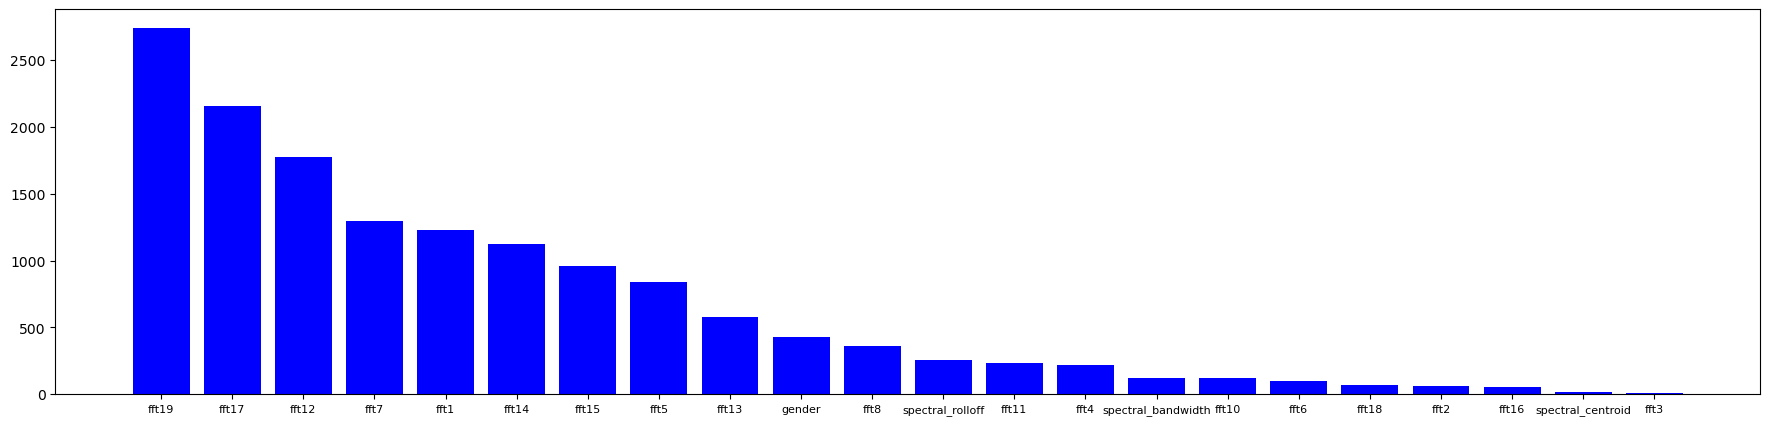

[2740.7739693  2155.8011698  1771.45583613 1298.54611465 1230.47573026
 1122.26283937  960.2997328   842.53092313  580.09621575  430.88211214
  361.13134094  257.71455732  237.14234813  218.25045739  123.8508979
  123.70108348  101.95168068   73.08615426   60.43789076   57.08113583
   17.79729838   11.30774883]


In [59]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

#choosing from top 22 most useful features
top = 22
best_features = SelectKBest(f_classif, k=top).fit(X_new, y_train)
X_new = best_features.transform(X_new)
X_test = best_features.transform(X_test)
scores = best_features.scores_
indices = np.argsort(scores)[::-1]

features = []
for i in range(top):
    features.append(df_features.columns[indices[i]])
    
plt.figure(figsize=(22, 5))
plt.bar(features, scores[indices[range(top)]], color='b')
plt.xticks(fontsize=8)
plt.show()
print(scores[indices[range(top)]])

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

# ou models
mlp = MLPClassifier()
xgb = XGBClassifier()

# parameters to gridsearch
mlp_params = {
    'hidden_layer_sizes': [(50, 50, 400), (100, ), (200,)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.00005, 0.0001]
}

xgb_params = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 150, 200],
    'learning_rate': [0.01, 0.1, 1],
}

# Gridsearching for best parameters
mlp_grid = GridSearchCV(mlp, mlp_params)
xgb_grid = GridSearchCV(xgb, xgb_params)

# Fit the grid search objects to the data
mlp_grid.fit(X_new, y_train)
xgb_grid.fit(X_new, y_train)

# Choosing best model
voting_clf = VotingClassifier(estimators=[
    ('mlp', mlp_grid.best_estimator_),
    ('xgb', xgb_grid.best_estimator_)
], voting='hard')

# Training best model
voting_clf.fit(X_new, y_train)

# Predicting
y_pred = voting_clf.predict(X_test)

# Calculating accuracy of the model
cm = accuracy_score(y_test, y_pred)
print(cm)

0.8626913081143517


In [32]:
model_for_gender = MLPClassifier(hidden_layer_sizes=(50, 50, 400), activation='relu', solver='adam', alpha=0.00005)
scaler_for_gender = StandardScaler()
X = scaler_for_gender.fit_transform(X)
X = best_features.transform(X)
model_for_gender.fit(X, y)

import joblib
filename_model = 'model_gender.sav'
filename_scaler = 'scaler_gender.joblib'
filename_bestf = 'bestf_gender.joblib'
joblib.dump(model_for_gender, filename_model)
joblib.dump(scaler_for_gender, filename_scaler)
joblib.dump(best_features, filename_bestf)

['bestf_gender4.joblib']